# Data Prep


In [49]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.2.2'

We begin using the Linear Regression as example

In [50]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = (
    torch.arange(start, end, step) # returns a vector with Shape(50)
    .unsqueeze(dim=1) #adds a dimension to the tensor Shape(50, 1) = 50 rows, 1 column
)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [51]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

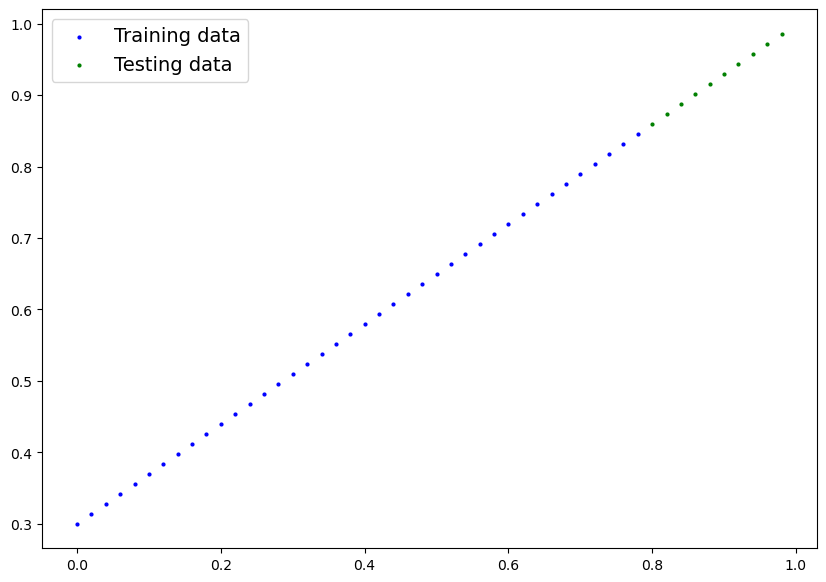

In [52]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

plot_predictions();

# Build Model

In [53]:
# A standardt Linear Regression Model using PyTorch

class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(
            torch.randn(
                1,                  # <- start with random weights (this will get adjusted as the model learns)
                dtype=torch.float   # <- PyTorch loves float32 by default
            ),
            requires_grad=True      # <- can we update this value with gradient descent?)
        )

        self.bias = nn.Parameter(
            torch.randn(
                1,                  # <- start with random weights (this will get adjusted as the model learns)
                dtype=torch.float   # <- PyTorch loves float32 by default
            ),
            requires_grad=True      # <- can we update this value with gradient descent?)
        )

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias             # <- this is the linear regression formula (y = m*x + b)

In [54]:
# Checking contents of a pytorch model

# Set random seed for reproducibility, as our parameters will be randomly initialized
torch.manual_seed(42) 

# Instantiate the model. This is a subclass of nn.Module that contains nn.Parameters for weights and biases
model_0 = LinearRegressionModel()


In [55]:
# 1. Get all parameters
params = list(model_0.parameters())
for i, param in enumerate(params):
    print(f"Parameter {i}: shape = {param.shape}")

# 2. Get named parameters
for name, param in model_0.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values: \n {param[:10]} \n")

# 3. View state dictionary
print("State Dict:")
print(model_0.state_dict())

# 4. Print layer-wise parameter count
def count_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if parameter.requires_grad:
            param_count = parameter.numel()
            print(f"Layer: {name} | Parameters: {param_count:,}")
            total_params += param_count
    print(f"\nTotal Trainable Parameters: {total_params:,}")
    
count_parameters(model_0)


Parameter 0: shape = torch.Size([1])
Parameter 1: shape = torch.Size([1])
Layer: weights | Size: torch.Size([1]) | Values: 
 tensor([0.3367], grad_fn=<SliceBackward0>) 

Layer: bias | Size: torch.Size([1]) | Values: 
 tensor([0.1288], grad_fn=<SliceBackward0>) 

State Dict:
OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])
Layer: weights | Parameters: 1
Layer: bias | Parameters: 1

Total Trainable Parameters: 2


Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


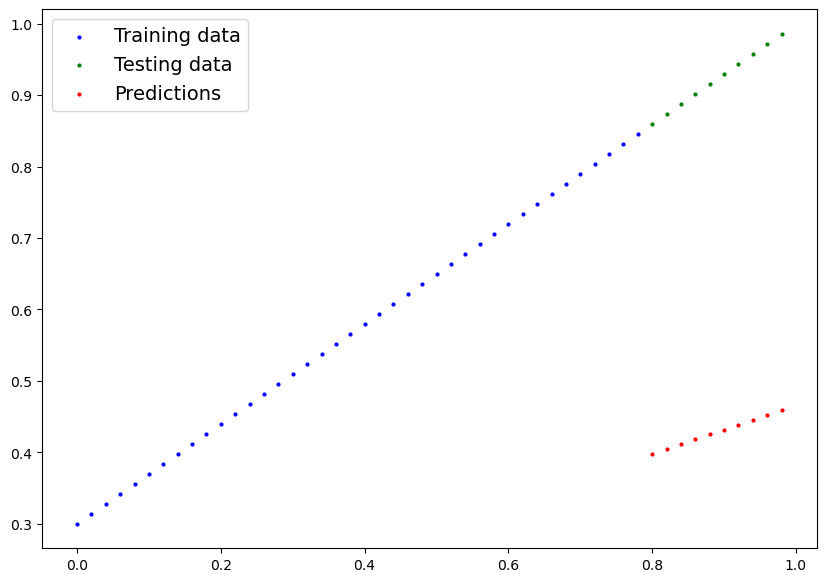

In [56]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)

# remember X_test.shape # Shape(10,1) = 10 samples, 1 feature

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")
plot_predictions(predictions=y_preds)

# Train model


## Define a loss function and an Optimizer
- Loss Function: MAE (Mean Absolute Error) `torch.nn.L1Loss()`
- Optimizer:  `torch.optim.SGD(params, lr)`
    - `params` is the target model parameters you'd like to optimize (e.g. the `weights` and `bias` values we randomly set before)
    - `lr` is the learning rate. It is considered an hyperparameter

In [57]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

### Create an optimization loop in pytorch

#### For training
- forward pass
- Calculate the loss
- Calculate evaluation metrics

#### For testing
- forward pass
- Calculate the loss
- Zero Gradients
- Perform backpropagation
- update the optimizer

In [61]:
torch.manual_seed(42) # Set random seed for reproducibility

epochs = 200

train_loss_values = [] 
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # put model on training mode
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer 
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5- progress the optimizer
    optimizer.step()


    ### Testing

    # Put the model in evaluate mode
    model_0.eval()

    with torch.inference_mode(): # <- turn off gradients for validation

        # 1. forward pass on test data 
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test.type(torch.float))# predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

        # 3. Print out what is happening
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")
    


Epoch: 0 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262 
Epoch: 10 | MAE Train Loss: 0.021020209416747093 | MAE Test Loss: 0.04819049686193466 
Epoch: 20 | MAE Train Loss: 0.01758546754717827 | MAE Test Loss: 0.04060482233762741 
Epoch: 30 | MAE Train Loss: 0.014155392535030842 | MAE Test Loss: 0.03233227878808975 
Epoch: 40 | MAE Train Loss: 0.010716588236391544 | MAE Test Loss: 0.024059748277068138 
Epoch: 50 | MAE Train Loss: 0.0072835348546504974 | MAE Test Loss: 0.016474086791276932 
Epoch: 60 | MAE Train Loss: 0.003851778106763959 | MAE Test Loss: 0.008201557211577892 
Epoch: 70 | MAE Train Loss: 0.00893248151987791 | MAE Test Loss: 0.005023092031478882 
Epoch: 80 | MAE Train Loss: 0.00893248151987791 | MAE Test Loss: 0.005023092031478882 
Epoch: 90 | MAE Train Loss: 0.00893248151987791 | MAE Test Loss: 0.005023092031478882 
Epoch: 100 | MAE Train Loss: 0.00893248151987791 | MAE Test Loss: 0.005023092031478882 
Epoch: 110 | MAE Train Loss: 0.008932481

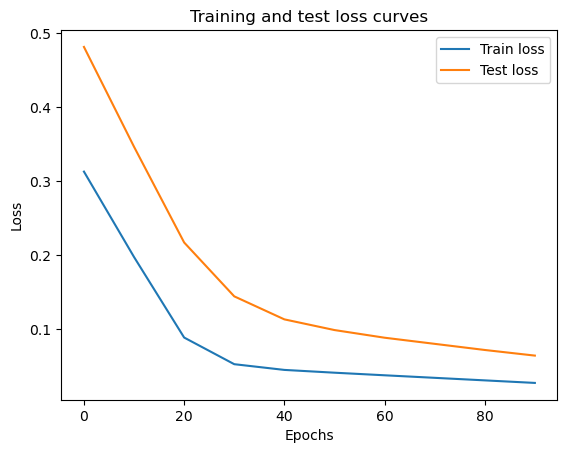

In [59]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [62]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# Predictions with a trained PyTorch model (Inference)

1. Set the model in evaluation mode (`mode.eval()`)
2. Make the predictions using the inferenc emode context manager(`with torch.inference_mode()`)
3. All predictions should be made with objects on the same device(e.g. data and dmodel on GPU only or data and model on CPU only)



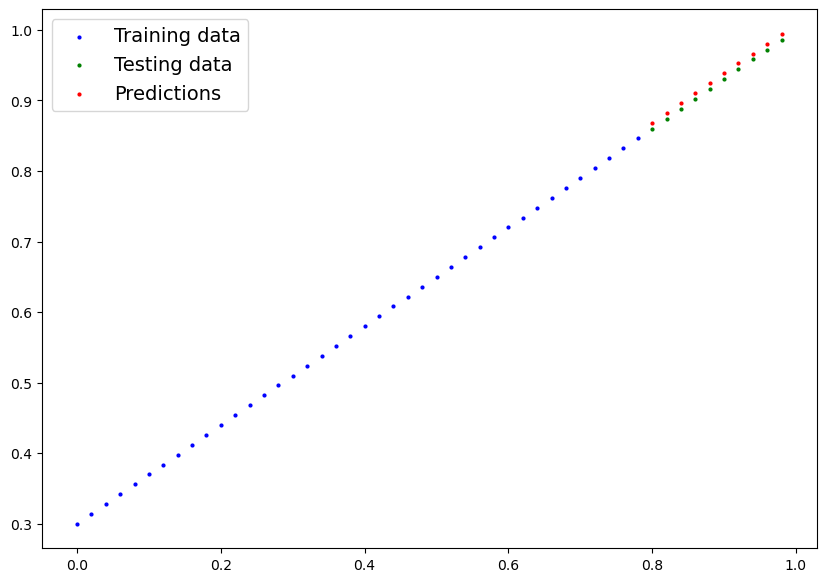

In [64]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Make the predictions using the interference mode context manager
with torch.inference_mode():
    # 3. Make sure the calculations are done with the model and data on the same device
    # in our case, we haven't seti`device-agmostic code yet so our data and model are on the CPU by default.
    # model_0.to(device)`
    # X_test = X_test.to(device)
    y_preds = model_0(X_test)

y_preds
plot_predictions(predictions=y_preds)

# Saving and loading a PyTorch model

In [65]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents= True, exist_ok= True)


# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(
    obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
    f=MODEL_SAVE_PATH
)

Saving model to: models/01_pytorch_workflow_model_0.pth


# Loading a saved PyTorch model's `state_dict()`

In [66]:
loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [67]:
# lets test our loaded model

# 1. Set the model in evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode(): # <- turn off gradients for validation
    loaded_model_preds = loaded_model_0(X_test)

# Compare previous model predictions with loaded model predictions(these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])